In [3]:
# ## Cell 1: 모듈 임포트 및 기본 설정
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys
import itertools
from scipy import stats

# src 폴더를 경로에 추가하여 analysis 모듈을 임포트
# 노트북 파일이 코드와 다른 디렉토리에 있다고 가정합니다.
# 경로가 다른 경우 이 부분을 수정해주세요. (예: sys.path.append('src'))
sys.path.append('../src')
import analysis

# --- 그래프 스타일 및 한글 폰트 설정 ---
sns.set_theme(style="whitegrid", palette="viridis")
try:
    plt.rcParams['font.family'] = 'AppleGothic' # macOS
    print("AppleGothic font is set.")
except:
    try:
        plt.rcParams['font.family'] = 'Malgun Gothic' # Windows
        print("Malgun Gothic font is set.")
    except:
        print("Font not found. Please set a font that supports Korean.")
plt.rcParams['axes.unicode_minus'] = False # 마이너스 폰트 깨짐 방지
print("-" * 50)

AppleGothic font is set.
--------------------------------------------------


In [7]:
# ## Cell 2: 데이터 로드 및 전처리
# main.py 실행 후 생성된 결과 파일 경로를 지정
results_file = Path("../results/text/evaluation_results/scoring_results.jsonl")

# analysis.py의 함수들을 사용하여 데이터프레임 생성
base_df = analysis.load_and_flatten_results(results_file)
processed_df = analysis.calculate_ensemble_scores(base_df)

print("데이터 로딩 및 전처리 완료")
print(f"총 {len(processed_df)}개의 심사 결과가 로드되었습니다.")
print("\n--- 데이터프레임 정보 ---")
processed_df.info()
print("\n--- 처리된 데이터프레임 샘플 (상위 5개) ---")
print(processed_df.head())
print("-" * 50)

2025-09-26 11:49:12 - INFO - 앙상블 점수 계산이 완료되었습니다.


데이터 로딩 및 전처리 완료
총 280개의 심사 결과가 로드되었습니다.

--- 데이터프레임 정보 ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280 entries, 0 to 279
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   doc_id               280 non-null    object 
 1   page_id              280 non-null    object 
 2   model                280 non-null    object 
 3   combo                280 non-null    object 
 4   question_text        280 non-null    object 
 5   question_type        280 non-null    object 
 6   question_difficulty  280 non-null    object 
 7   answer               280 non-null    object 
 8   prompt_tokens        280 non-null    int64  
 9   completion_tokens    280 non-null    int64  
 10  judge                280 non-null    object 
 11  accuracy             280 non-null    float64
 12  groundedness         280 non-null    float64
 13  completeness         280 non-null    float64
 14  clarity              280 non-nu

In [8]:
# ## Cell 3: 심사관 간 일치도(Inter-Annotator Agreement) 분석
# 여러 페르소나(심사관)의 평가가 얼마나 일관적인지 확인합니다.
# Krippendorff's Alpha는 심사 결과의 신뢰도를 나타내는 중요한 지표입니다.
# (0.8 이상: 매우 높음, 0.67 ~ 0.8: 신뢰할만함, 0.67 미만: 주의 필요)
alpha = analysis.calculate_krippendorff_alpha(processed_df)
print(f"전체 심사관 간 일치도 (Krippendorff's Alpha): {alpha:.4f}")
print("이 값이 너무 낮다면, 심사 프롬프트나 페르소나 정의를 재검토해야 합니다.")
print("-" * 50)

2025-09-26 11:49:15 - INFO - Krippendorff's Alpha: 0.9509


전체 심사관 간 일치도 (Krippendorff's Alpha): 0.9509
이 값이 너무 낮다면, 심사 프롬프트나 페르소나 정의를 재검토해야 합니다.
--------------------------------------------------


2025-09-26 11:49:17 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.



입력 조합(combo)별 앙상블 점수 요약:
               mean           std  count           sem          ci95
combo                                                               
M3     4.468648e-16  1.437088e-15     40  2.272235e-16  4.453581e-16
M1     1.498801e-16  6.616350e-16     40  1.046137e-16  2.050428e-16
M4     1.498801e-16  6.616350e-16     40  1.046137e-16  2.050428e-16
M2     0.000000e+00  0.000000e+00     40  0.000000e+00  0.000000e+00
M5     0.000000e+00  0.000000e+00     40  0.000000e+00  0.000000e+00
M6     0.000000e+00  0.000000e+00     40  0.000000e+00  0.000000e+00
M7     0.000000e+00  0.000000e+00     40  0.000000e+00  0.000000e+00


/var/folders/xd/lx8sp2hd5g1ddgqnh7k9xcmh0000gn/T/ipykernel_50632/2988374696.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


ValueError: 'xerr' (shape: (7,)) must be a scalar or a 1D or (2, n) array-like whose shape matches 'x' (shape: (1,))

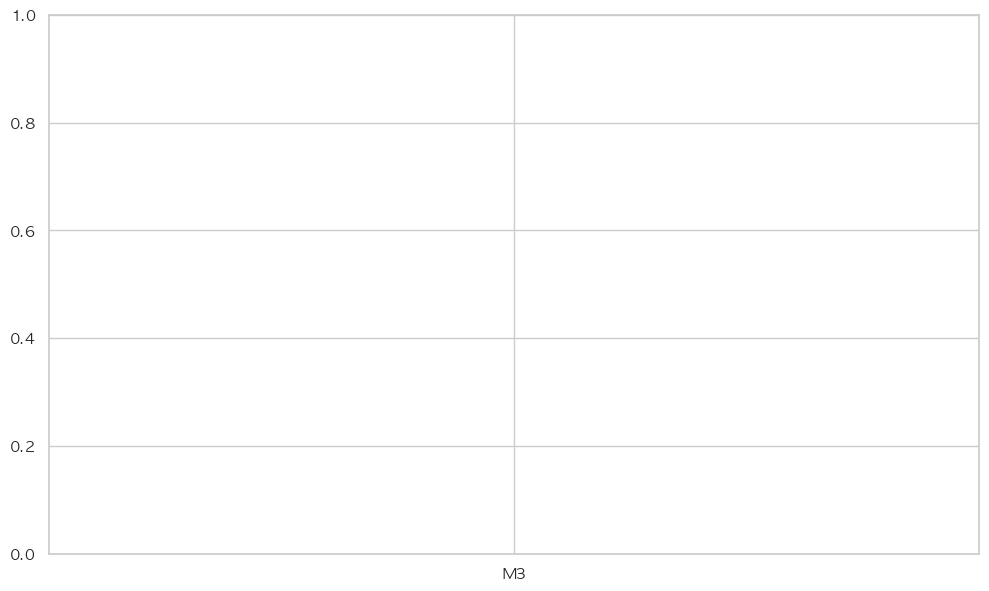

In [9]:
# ## Cell 4: 전체 성능 요약 및 신뢰도 구간 시각화
print("\n입력 조합(combo)별 앙상블 점수 요약:")
summary = processed_df.groupby('combo')['ensemble_score'].agg(['mean', 'std', 'count', 'sem']).sort_values('mean', ascending=False)
summary['ci95'] = summary['sem'] * 1.96 # 95% 신뢰구간
print(summary)

# --- 시각화: 신뢰구간을 포함한 막대그래프 ---
plt.figure(figsize=(12, 7))
sns.barplot(
    x=summary.index,
    y=summary['mean'],
    xerr=summary['ci95'], # 95% 신뢰구간 오차 막대 추가
    capsize=0.1,
    palette="viridis"
)
plt.title('입력 조합(combo)별 평균 앙상블 점수 (95% 신뢰구간 포함)', fontsize=16, pad=20)
plt.xlabel('입력 조합 (Combo)', fontsize=12)
plt.ylabel('평균 앙상블 점수', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

2025-09-26 11:50:51 - WARNING - 공통 답변 수가 너무 적어 (0개) 통계 검정을 건너뜁니다.
2025-09-26 11:50:51 - WARNING - 공통 답변 수가 너무 적어 (0개) 통계 검정을 건너뜁니다.
2025-09-26 11:50:51 - WARNING - 공통 답변 수가 너무 적어 (0개) 통계 검정을 건너뜁니다.
2025-09-26 11:50:51 - WARNING - 공통 답변 수가 너무 적어 (0개) 통계 검정을 건너뜁니다.
2025-09-26 11:50:51 - WARNING - 공통 답변 수가 너무 적어 (0개) 통계 검정을 건너뜁니다.
2025-09-26 11:50:51 - WARNING - 공통 답변 수가 너무 적어 (0개) 통계 검정을 건너뜁니다.
2025-09-26 11:50:51 - WARNING - 공통 답변 수가 너무 적어 (0개) 통계 검정을 건너뜁니다.
2025-09-26 11:50:51 - WARNING - 공통 답변 수가 너무 적어 (0개) 통계 검정을 건너뜁니다.
2025-09-26 11:50:51 - WARNING - 공통 답변 수가 너무 적어 (0개) 통계 검정을 건너뜁니다.
2025-09-26 11:50:51 - WARNING - 공통 답변 수가 너무 적어 (0개) 통계 검정을 건너뜁니다.
2025-09-26 11:50:51 - WARNING - 공통 답변 수가 너무 적어 (0개) 통계 검정을 건너뜁니다.
2025-09-26 11:50:51 - WARNING - 공통 답변 수가 너무 적어 (0개) 통계 검정을 건너뜁니다.
2025-09-26 11:50:51 - WARNING - 공통 답변 수가 너무 적어 (0개) 통계 검정을 건너뜁니다.
2025-09-26 11:50:51 - WARNING - 공통 답변 수가 너무 적어 (0개) 통계 검정을 건너뜁니다.
2025-09-26 11:50:51 - WARNING - 공통 답변 수가 너무 적어 (0개) 통계 검정을 건너뜁니다.
2025-09-26

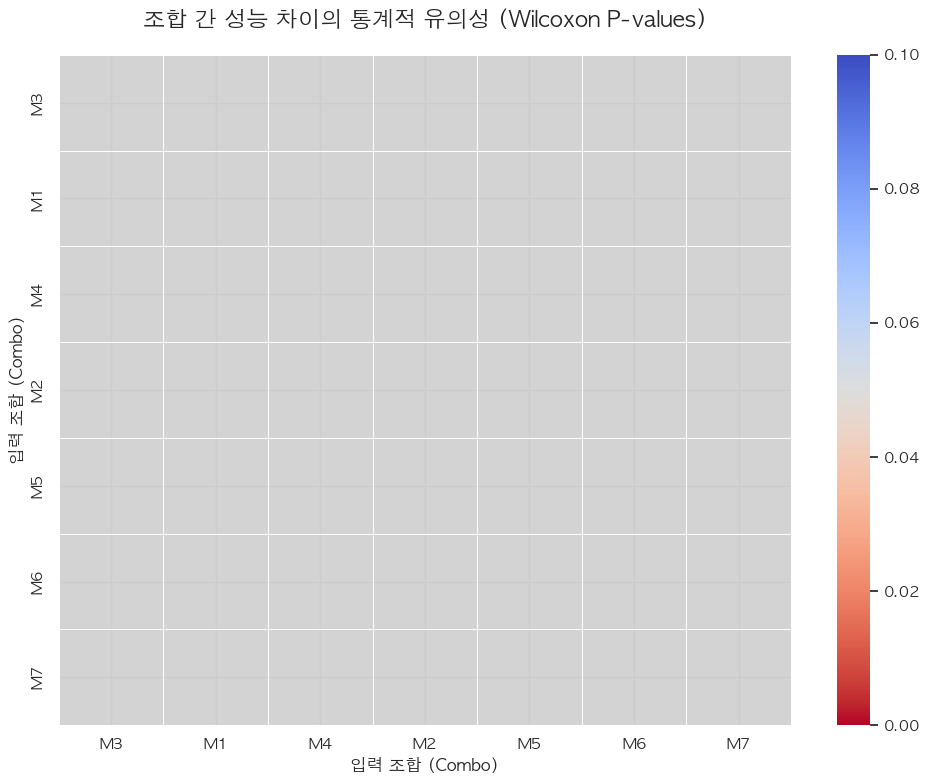

heatmap에서 값이 0.05 미만이면 두 조합 간 성능 차이가 통계적으로 유의미하다고 해석할 수 있습니다.
--------------------------------------------------


In [10]:
# ## Cell 5: 통계적 유의성 검정 (Pairwise P-value Heatmap)
# 어떤 조합 간의 성능 차이가 통계적으로 유의미한지 한눈에 파악합니다.
# Wilcoxon signed-rank test는 쌍을 이룬 데이터의 중앙값 차이를 검정하는 비모수적 방법입니다.

combos = summary.index.tolist()
p_value_matrix = pd.DataFrame(index=combos, columns=combos, dtype=float)

for combo1, combo2 in itertools.combinations(combos, 2):
    # analysis.py의 함수를 재사용하여 p-value 계산
    _, p_value = analysis.run_statistical_test(processed_df, combo1, combo2)
    p_value_matrix.loc[combo1, combo2] = p_value
    p_value_matrix.loc[combo2, combo1] = p_value

# --- 시각화: P-value Heatmap ---
plt.figure(figsize=(10, 8))
sns.heatmap(
    p_value_matrix,
    annot=True,
    fmt=".4f",
    cmap="coolwarm_r", # p-value가 낮을수록 붉은색
    linewidths=.5,
    vmin=0,
    vmax=0.1 # p-value의 상한을 0.1로 설정하여 미세한 차이 강조
)
plt.title('조합 간 성능 차이의 통계적 유의성 (Wilcoxon P-values)', fontsize=16, pad=20)
plt.xlabel('입력 조합 (Combo)', fontsize=12)
plt.ylabel('입력 조합 (Combo)', fontsize=12)
plt.gca().set_facecolor('lightgray') # NaN 값 배경색 설정
plt.tight_layout()
plt.show()
print("heatmap에서 값이 0.05 미만이면 두 조합 간 성능 차이가 통계적으로 유의미하다고 해석할 수 있습니다.")
print("-" * 50)

2025-09-26 11:51:02 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
/var/folders/xd/lx8sp2hd5g1ddgqnh7k9xcmh0000gn/T/ipykernel_50632/4083700160.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
2025-09-26 11:51:02 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-09-26 11:51:02 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
/var/folders/xd/lx8sp2hd5g1ddgqnh7k9xcmh0000gn/T/ipykernel_506

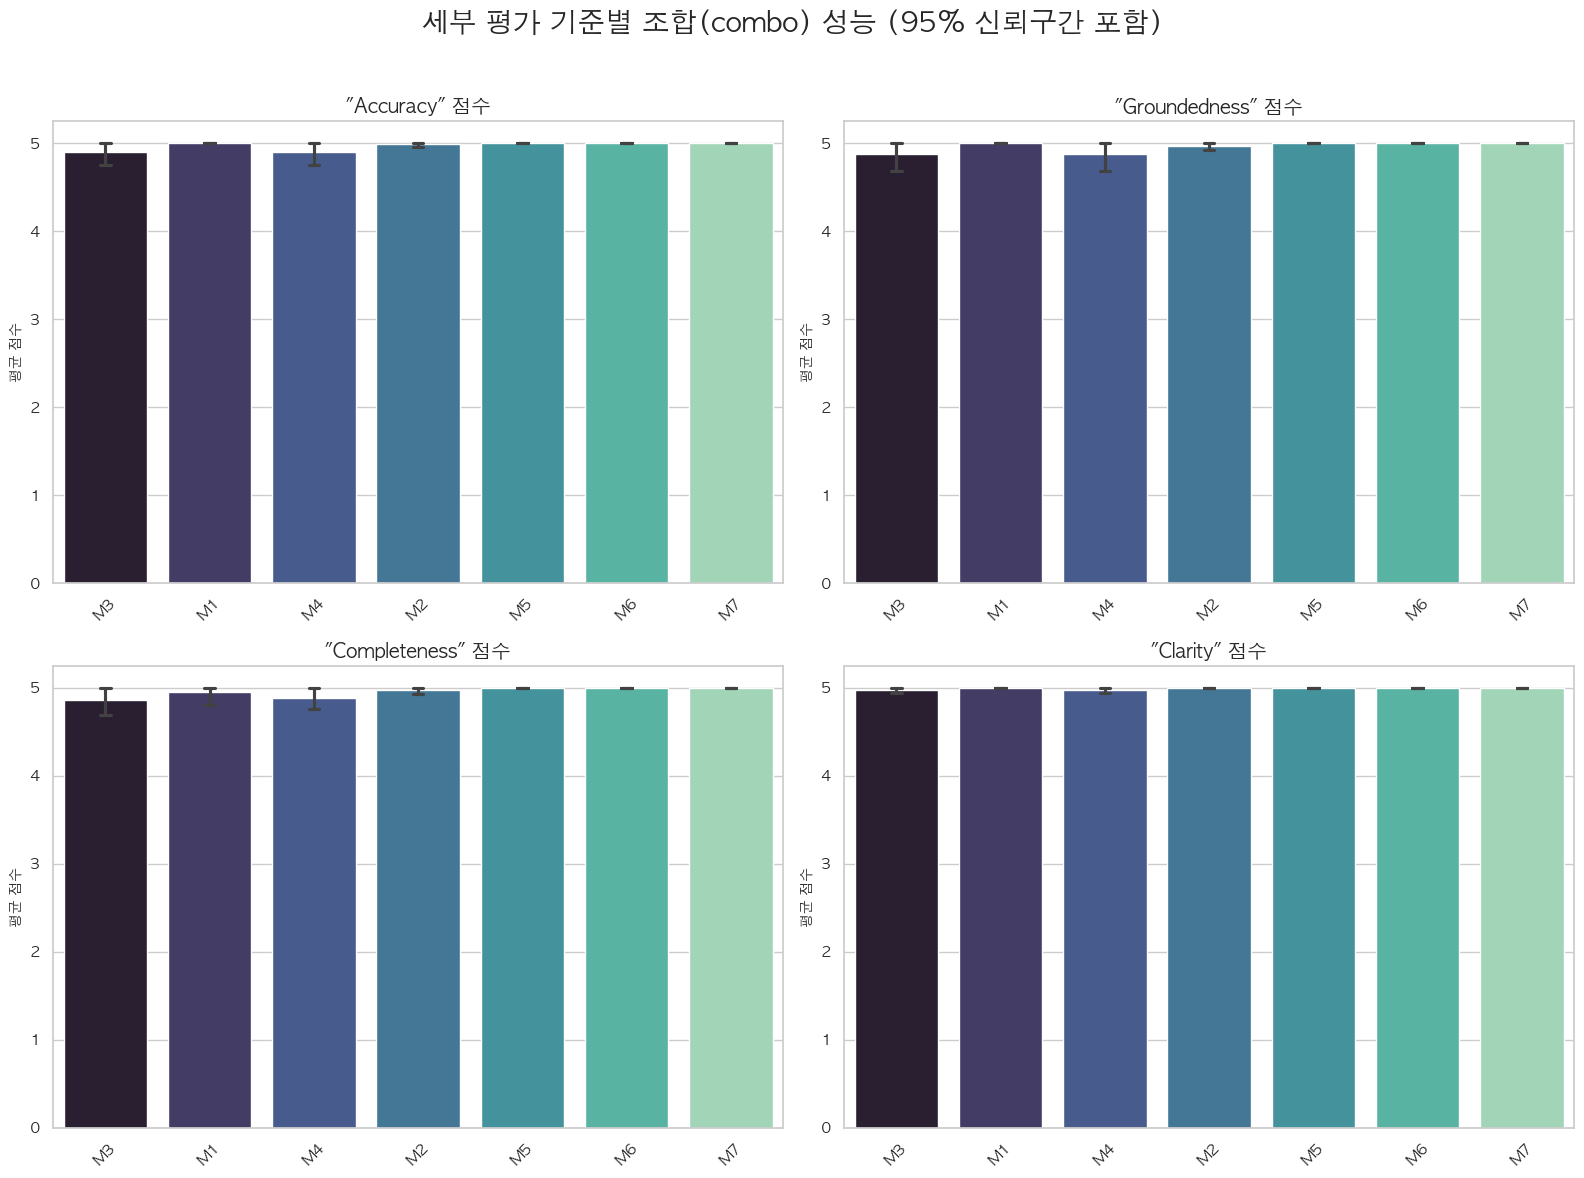

--------------------------------------------------


In [11]:
# ## Cell 6: 세부 평가 기준별 성능 분석
# `accuracy`, `groundedness` 등 각 기준별로 어떤 조합이 뛰어난지 분석합니다.
metrics = ['accuracy', 'groundedness', 'completeness', 'clarity']

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('세부 평가 기준별 조합(combo) 성능 (95% 신뢰구간 포함)', fontsize=20)

# summary 데이터프레임의 순서를 사용하기 위해 combo_order를 정의
combo_order = summary.index

for i, metric in enumerate(metrics):
    ax = axes[i//2, i%2]
    sns.barplot(
        data=processed_df,
        x='combo',
        y=metric,
        order=combo_order, # 전체 점수 순서로 정렬
        ax=ax,
        errorbar=('ci', 95), # seaborn에서 바로 95% CI 계산
        capsize=0.1,
        palette="mako"
    )
    ax.set_title(f'"{metric.capitalize()}" 점수', fontsize=14)
    ax.set_xlabel('')
    ax.set_ylabel('평균 점수', fontsize=10)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
print("-" * 50)

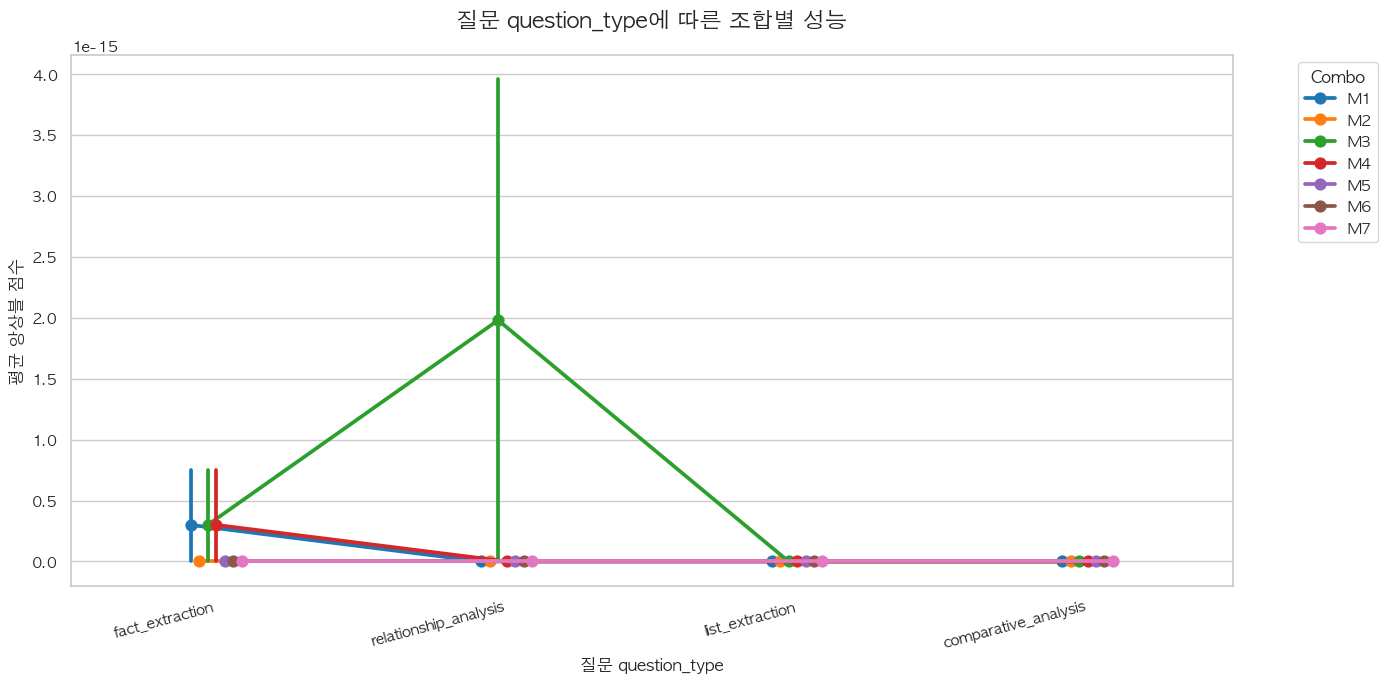

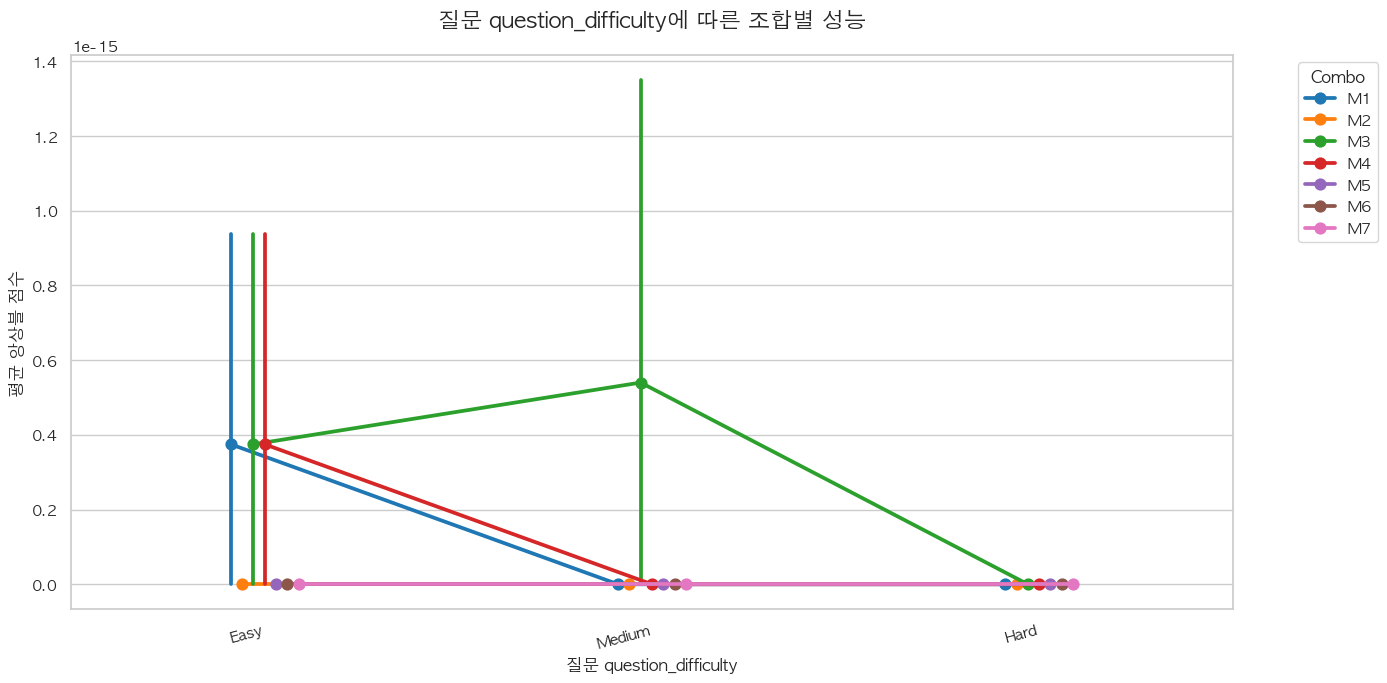

--------------------------------------------------


In [12]:
# ## Cell 7: 질문 유형 및 난이도별 심층 분석
# 특정 유형의 질문이나 어려운 질문에서 모델들의 성능이 어떻게 달라지는지 확인합니다.
analysis_dims = ['question_type', 'question_difficulty']

for dim in analysis_dims:
    plt.figure(figsize=(14, 7))
    sns.pointplot(
        data=processed_df,
        x=dim,
        y='ensemble_score',
        hue='combo',
        errorbar=('ci', 95),
        dodge=True, # 그룹별로 점을 살짝 띄움
        palette='tab10'
    )
    plt.title(f'질문 {dim}에 따른 조합별 성능', fontsize=16, pad=20)
    plt.xlabel(f'질문 {dim}', fontsize=12)
    plt.ylabel('평균 앙상블 점수', fontsize=12)
    plt.xticks(rotation=15, ha='right')
    plt.legend(title='Combo', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

print("-" * 50)

✅ 모든 분석이 완료되었습니다.


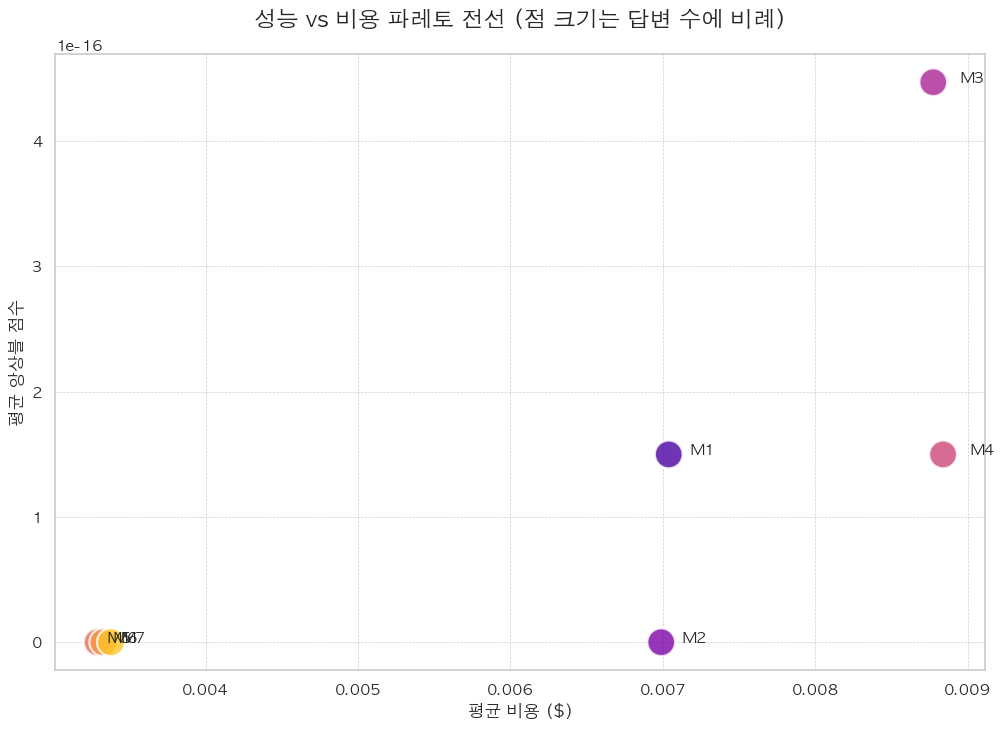

In [13]:
# ## Cell 8: 비용-성능 파레토 최적 전선(Pareto Frontier) 분석
# 비용과 성능을 동시에 고려하여 가장 효율적인 조합을 찾습니다.
# 점의 크기는 답변 생성 건수(신뢰도)를 나타냅니다.
PRICING = {
    "prompt_tokens": 0.005 / 1000, # GPT-4o 입력 토큰 가격 (가정)
    "completion_tokens": 0.015 / 1000 # GPT-4o 출력 토큰 가격 (가정)
}
# 토큰 정보가 없는 경우를 대비하여 0으로 채움
processed_df['prompt_tokens'] = processed_df['prompt_tokens'].fillna(0)
processed_df['completion_tokens'] = processed_df['completion_tokens'].fillna(0)

processed_df['cost'] = (processed_df['prompt_tokens'] * PRICING['prompt_tokens'] +
                        processed_df['completion_tokens'] * PRICING['completion_tokens'])

# 콤보별 평균 점수, 비용, 답변 수 계산
pareto_data = processed_df.groupby('combo').agg(
    avg_score=('ensemble_score', 'mean'),
    avg_cost=('cost', 'mean'),
    count=('ensemble_score', 'size') # 답변 수 추가
).reset_index()

plt.figure(figsize=(12, 8))
# 점의 크기(size)를 답변 수(count)에 비례하도록 설정
scatter = sns.scatterplot(
    data=pareto_data,
    x='avg_cost',
    y='avg_score',
    s=pareto_data['count'] * 10,  # 답변 수에 비례하여 점 크기 조절
    hue='combo',
    legend=False,
    palette="plasma",
    alpha=0.8
)
plt.title('성능 vs 비용 파레토 전선 (점 크기는 답변 수에 비례)', fontsize=16, pad=20)
plt.xlabel('평균 비용 ($)', fontsize=12)
plt.ylabel('평균 앙상블 점수', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# 각 점에 라벨 추가
for i, point in pareto_data.iterrows():
    plt.text(point['avg_cost'] * 1.02, point['avg_score'], point['combo'], fontsize=11)

print("✅ 모든 분석이 완료되었습니다.")
plt.show()